In [1]:
!date

Wed Jun 12 17:13:33 PDT 2019


# Supplementary Note Figure 3

In [7]:
import glob
import pandas as pd
import numpy as np
import pandas as pd
import scipy as scp
import sklearn
import itertools
from scipy.optimize import fsolve
from upsetplot import generate_data, plot, from_memberships
from collections import Counter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

In [2]:
v2_names = np.array(['SRR8599150_v2',
       'heart1k_v2', 'SRR8611943_v2',
       'SRR8257100_v2', 'EMTAB7320_v2',
       'SRR7299563_v2', 'SRR8513910_v2',
       'SRR8639063_v2', 'SRR8524760_v2',
       'SRR6956073_v2', 'hgmm1k_v2',
       'SRR8206317_v2', 'SRR8327928_v2',
       'SRR6998058_v2'], dtype=object)

v3_names = np.array(['pbmc_1k_v3', 'hgmm10k_v3',
       'neuron_10k_v3', 'pbmc_10k_v3',
       'heart1k_v3', 'hgmm1k_v3'], dtype=object)

In [3]:
v2_data = {}
v2_data["EMTAB7320_v2"]  = {"n_reads": 335147976}
v2_data["heart1k_v2"]  = {"n_reads": 88872840}
v2_data["hgmm1k_v2"] = {"n_reads": 75225120}
v2_data["SRR6956073_v2"] = {"n_reads": 161274652}
v2_data["SRR6998058_v2"] = {"n_reads": 37227612}
v2_data["SRR7299563_v2"]  = {"n_reads": 112176350}
v2_data["SRR8206317_v2"] = {"n_reads": 85992089}
v2_data["SRR8257100_v2"]  = {"n_reads": 189337914}
v2_data["SRR8327928_v2"] = {"n_reads": 190094560}
v2_data["SRR8513910_v2"]  = {"n_reads": 146617182}
v2_data["SRR8524760_v2"]  = {"n_reads": 97106426}
v2_data["SRR8599150_v2"]  = {"n_reads": 8860361}
v2_data["SRR8611943_v2"]  = {"n_reads": 21574502}
v2_data["SRR8639063_v2"]  = {"n_reads": 416437344}

v2_data["EMTAB7320_v2"]["n_cells"] = 4510
v2_data["heart1k_v2"]["n_cells"] = 712
v2_data["hgmm1k_v2"]["n_cells"] = 1079
v2_data["SRR6956073_v2"]["n_cells"] = 4168
v2_data["SRR6998058_v2"]["n_cells"] = 575
v2_data["SRR7299563_v2"]["n_cells"] = 1660
v2_data["SRR8206317_v2"]["n_cells"] = 4418
v2_data["SRR8257100_v2"]["n_cells"] = 11685
v2_data["SRR8327928_v2"]["n_cells"] = 10396
v2_data["SRR8513910_v2"]["n_cells"] = 726
v2_data["SRR8524760_v2"]["n_cells"] = 3064
v2_data["SRR8599150_v2"]["n_cells"] = 3949
v2_data["SRR8611943_v2"]["n_cells"] = 5194
v2_data["SRR8639063_v2"]["n_cells"] = 6614

In [4]:
v3_data = {}
v3_data["hgmm1k_v3"] = {"n_reads": 63105786}
v3_data["neuron_10k_v3"] = {"n_reads": 357111595}
v3_data["pbmc_10k_v3"] = {"n_reads": 638901019}
v3_data["pbmc_1k_v3"] = {"n_reads": 66601887}
v3_data["heart1k_v3"] = {"n_reads": 84512390}
v3_data["hgmm10k_v3"] = {"n_reads": 721180737}

v3_data["hgmm1k_v3"]["n_cells"] = 1011
v3_data["neuron_10k_v3"]["n_cells"] = 11477
v3_data["pbmc_10k_v3"]["n_cells"] = 1045
v3_data["pbmc_1k_v3"]["n_cells"] = 11790
v3_data["heart1k_v3"]["n_cells"] = 11692
v3_data["hgmm10k_v3"]["n_cells"] = 1227

In [5]:
%%time
for f in glob.glob("/home/sina/projects/bus/validate/all_bus/k*"):
    name = "_".join(f.split("/")[7].split("_")[1:])
    print(name)
    if "v2" in name:
        # Dataframe of umis and how many cells they occur in
        tmp = pd.read_csv(f + "/umicelldist.txt", header=None, sep="\t", names=["umi", "count"])
        tmp.name = name
        v2_data[name]["umicelldist"] = tmp
        
    elif "v3" in name:
        tmp = pd.read_csv(f + "/umicelldist.txt", header=None, sep="\t", names=["umi", "count"])
        tmp.name = name
        v3_data[name]["umicelldist"] = tmp

pbmc_1k_v3
SRR8599150_v2
heart1k_v2
SRR8611943_v2
hgmm10k_v3
neuron_10k_v3
SRR8257100_v2
EMTAB7320_v2
SRR7299563_v2
SRR8513910_v2
SRR8639063_v2
pbmc_10k_v3
SRR8524760_v2
SRR6956073_v2
heart1k_v3
hgmm1k_v2
hgmm1k_v3
SRR8206317_v2
SRR8327928_v2
SRR6998058_v2
CPU times: user 44.8 s, sys: 5.51 s, total: 50.3 s
Wall time: 50.9 s


# Supplementary Note Figure

### v2

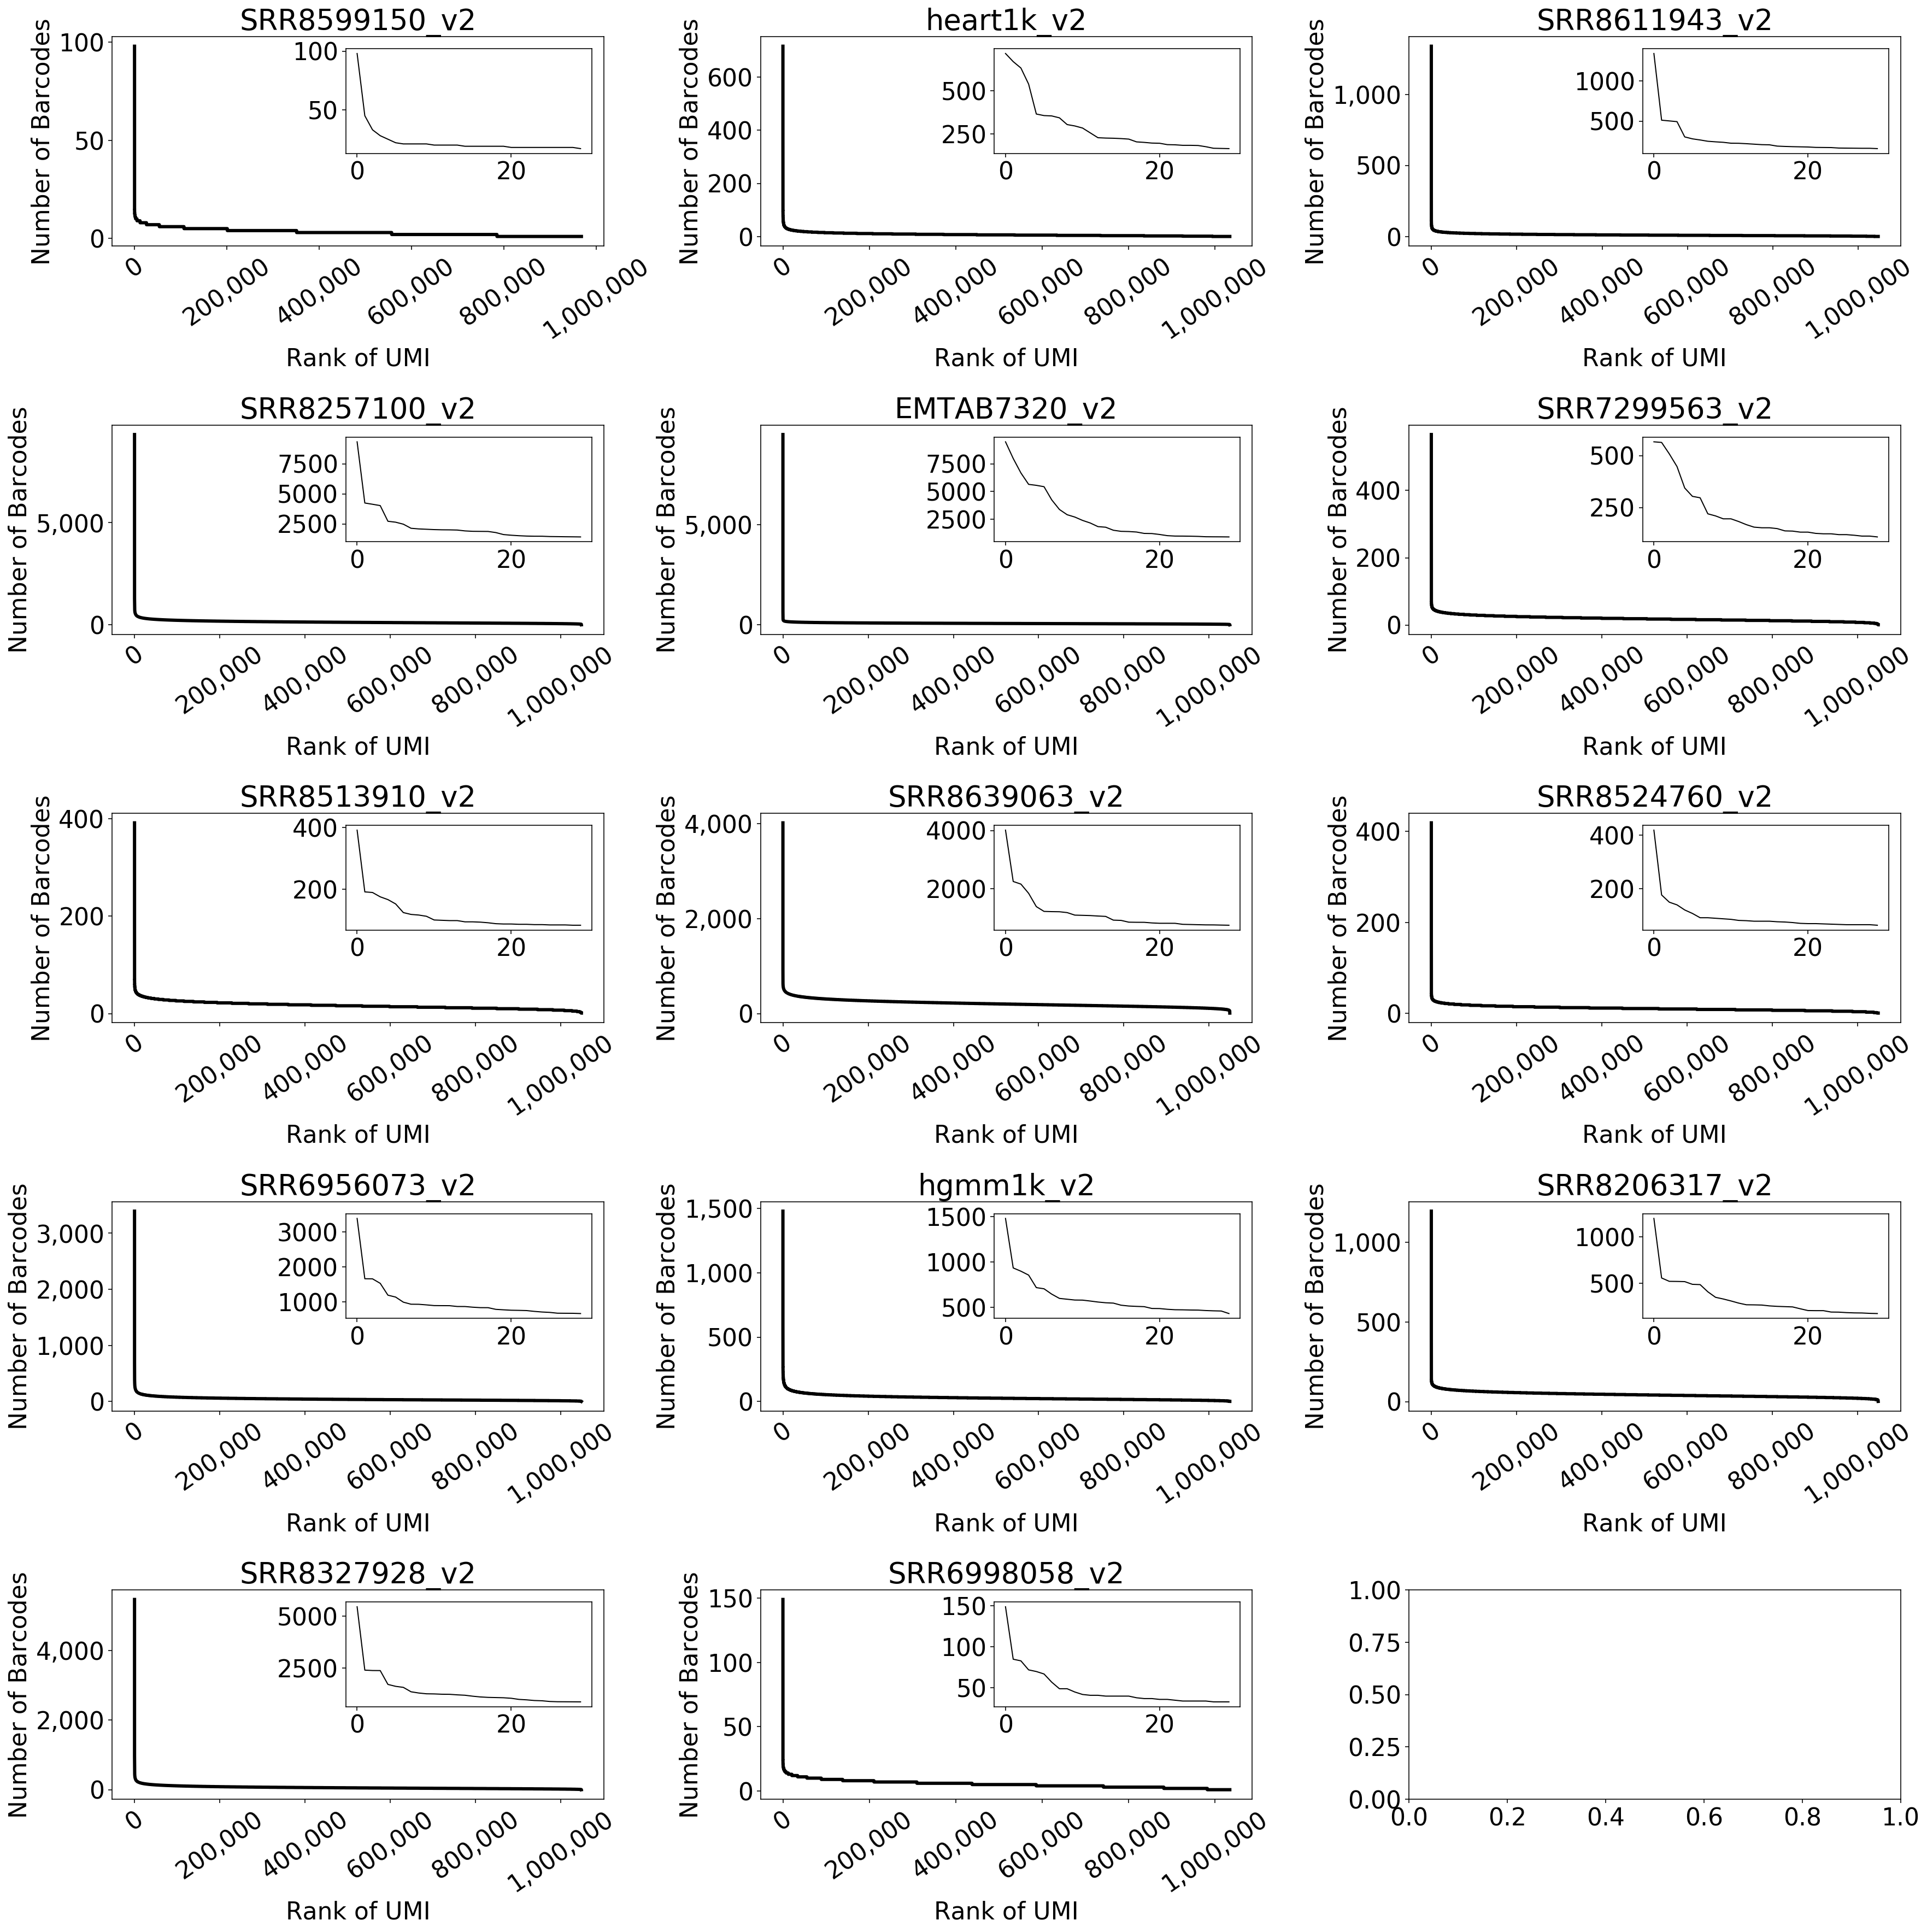

In [10]:
fig, axs = plt.subplots(5,3, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.75, wspace=0.5)
axs = axs.ravel()

for i in range(len(v2_names)):
    top = 30
    thresh = 1
    
    counts = np.sort(v2_data[v2_names[i]]["umicelldist"]["count"])


    axs[i].plot(range(len(counts))[::-1], counts, color="k", linewidth=3)
    
    inset = inset_axes(axs[i], width="50%", height="50%", loc=1)
    parts = inset.plot(range(len(counts[-top::]))[::-1], counts[-top::], color="k", linewidth=1)

    axs[i].set_title(v2_names[i])
    
    axs[i].set_xlabel("Rank of UMI")
    axs[i].set_ylabel("Number of Barcodes")
    
    axs[i].get_xaxis().set_visible(True)
    axs[i].get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axs[i].get_xaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))



    for tick in axs[i].get_xticklabels():
        tick.set_rotation(35)
plt.tight_layout()
#plt.savefig("v2_uniform.pdf")
plt.show()

### v3

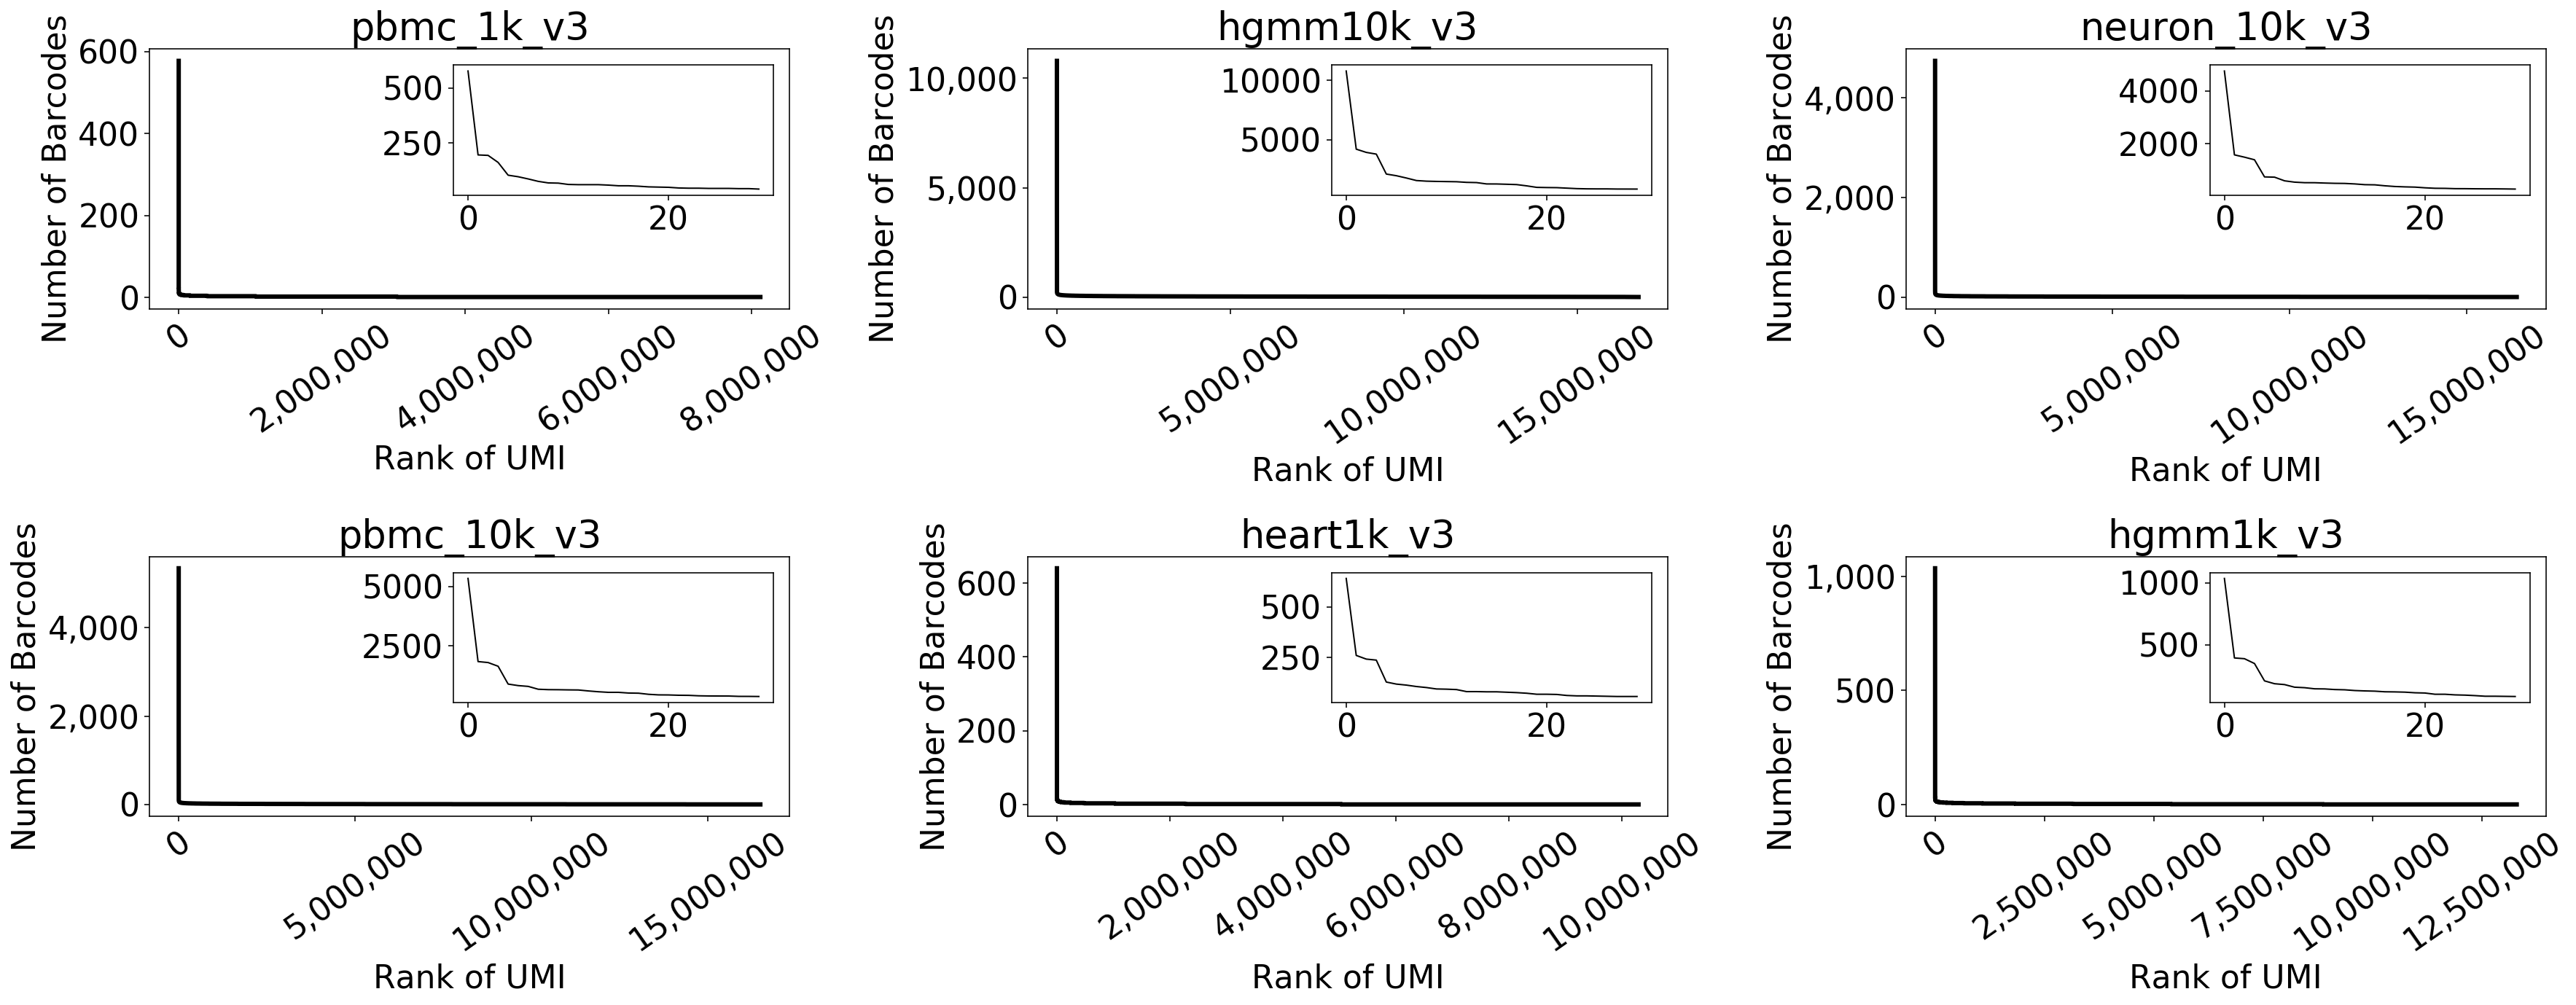

In [9]:
fig, axs = plt.subplots(2,3, figsize=(25, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.75, wspace=0.5)
axs = axs.ravel()

for i in range(len(v3_names)):
    top = 30
    thresh = 1
    
    counts = np.sort(v3_data[v3_names[i]]["umicelldist"]["count"])


    axs[i].plot(range(len(counts))[::-1], counts, color="k", linewidth=3)
    
    inset = inset_axes(axs[i], width="50%", height="50%", loc=1)
    parts = inset.plot(range(len(counts[-top::]))[::-1], counts[-top::], color="k", linewidth=1)

    axs[i].set_title(v3_names[i])
    
    axs[i].set_xlabel("Rank of UMI")
    axs[i].set_ylabel("Number of Barcodes")
    
    axs[i].get_xaxis().set_visible(True)
    axs[i].get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axs[i].get_xaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))


    for tick in axs[i].get_xticklabels():
        tick.set_rotation(35)
plt.tight_layout()
plt.savefig("v3_uniform.pdf")
plt.show()

### Combined

In [20]:
names = v2_names 
n3 = v3_names
names = np.append(names, n3)

data =[np.sort(v2_data[i]["umicelldist"]["count"]) for i in v2_names]

[data.append(np.sort(v3_data[i]["umicelldist"]["count"])) for i in v3_names]

[None, None, None, None, None, None]

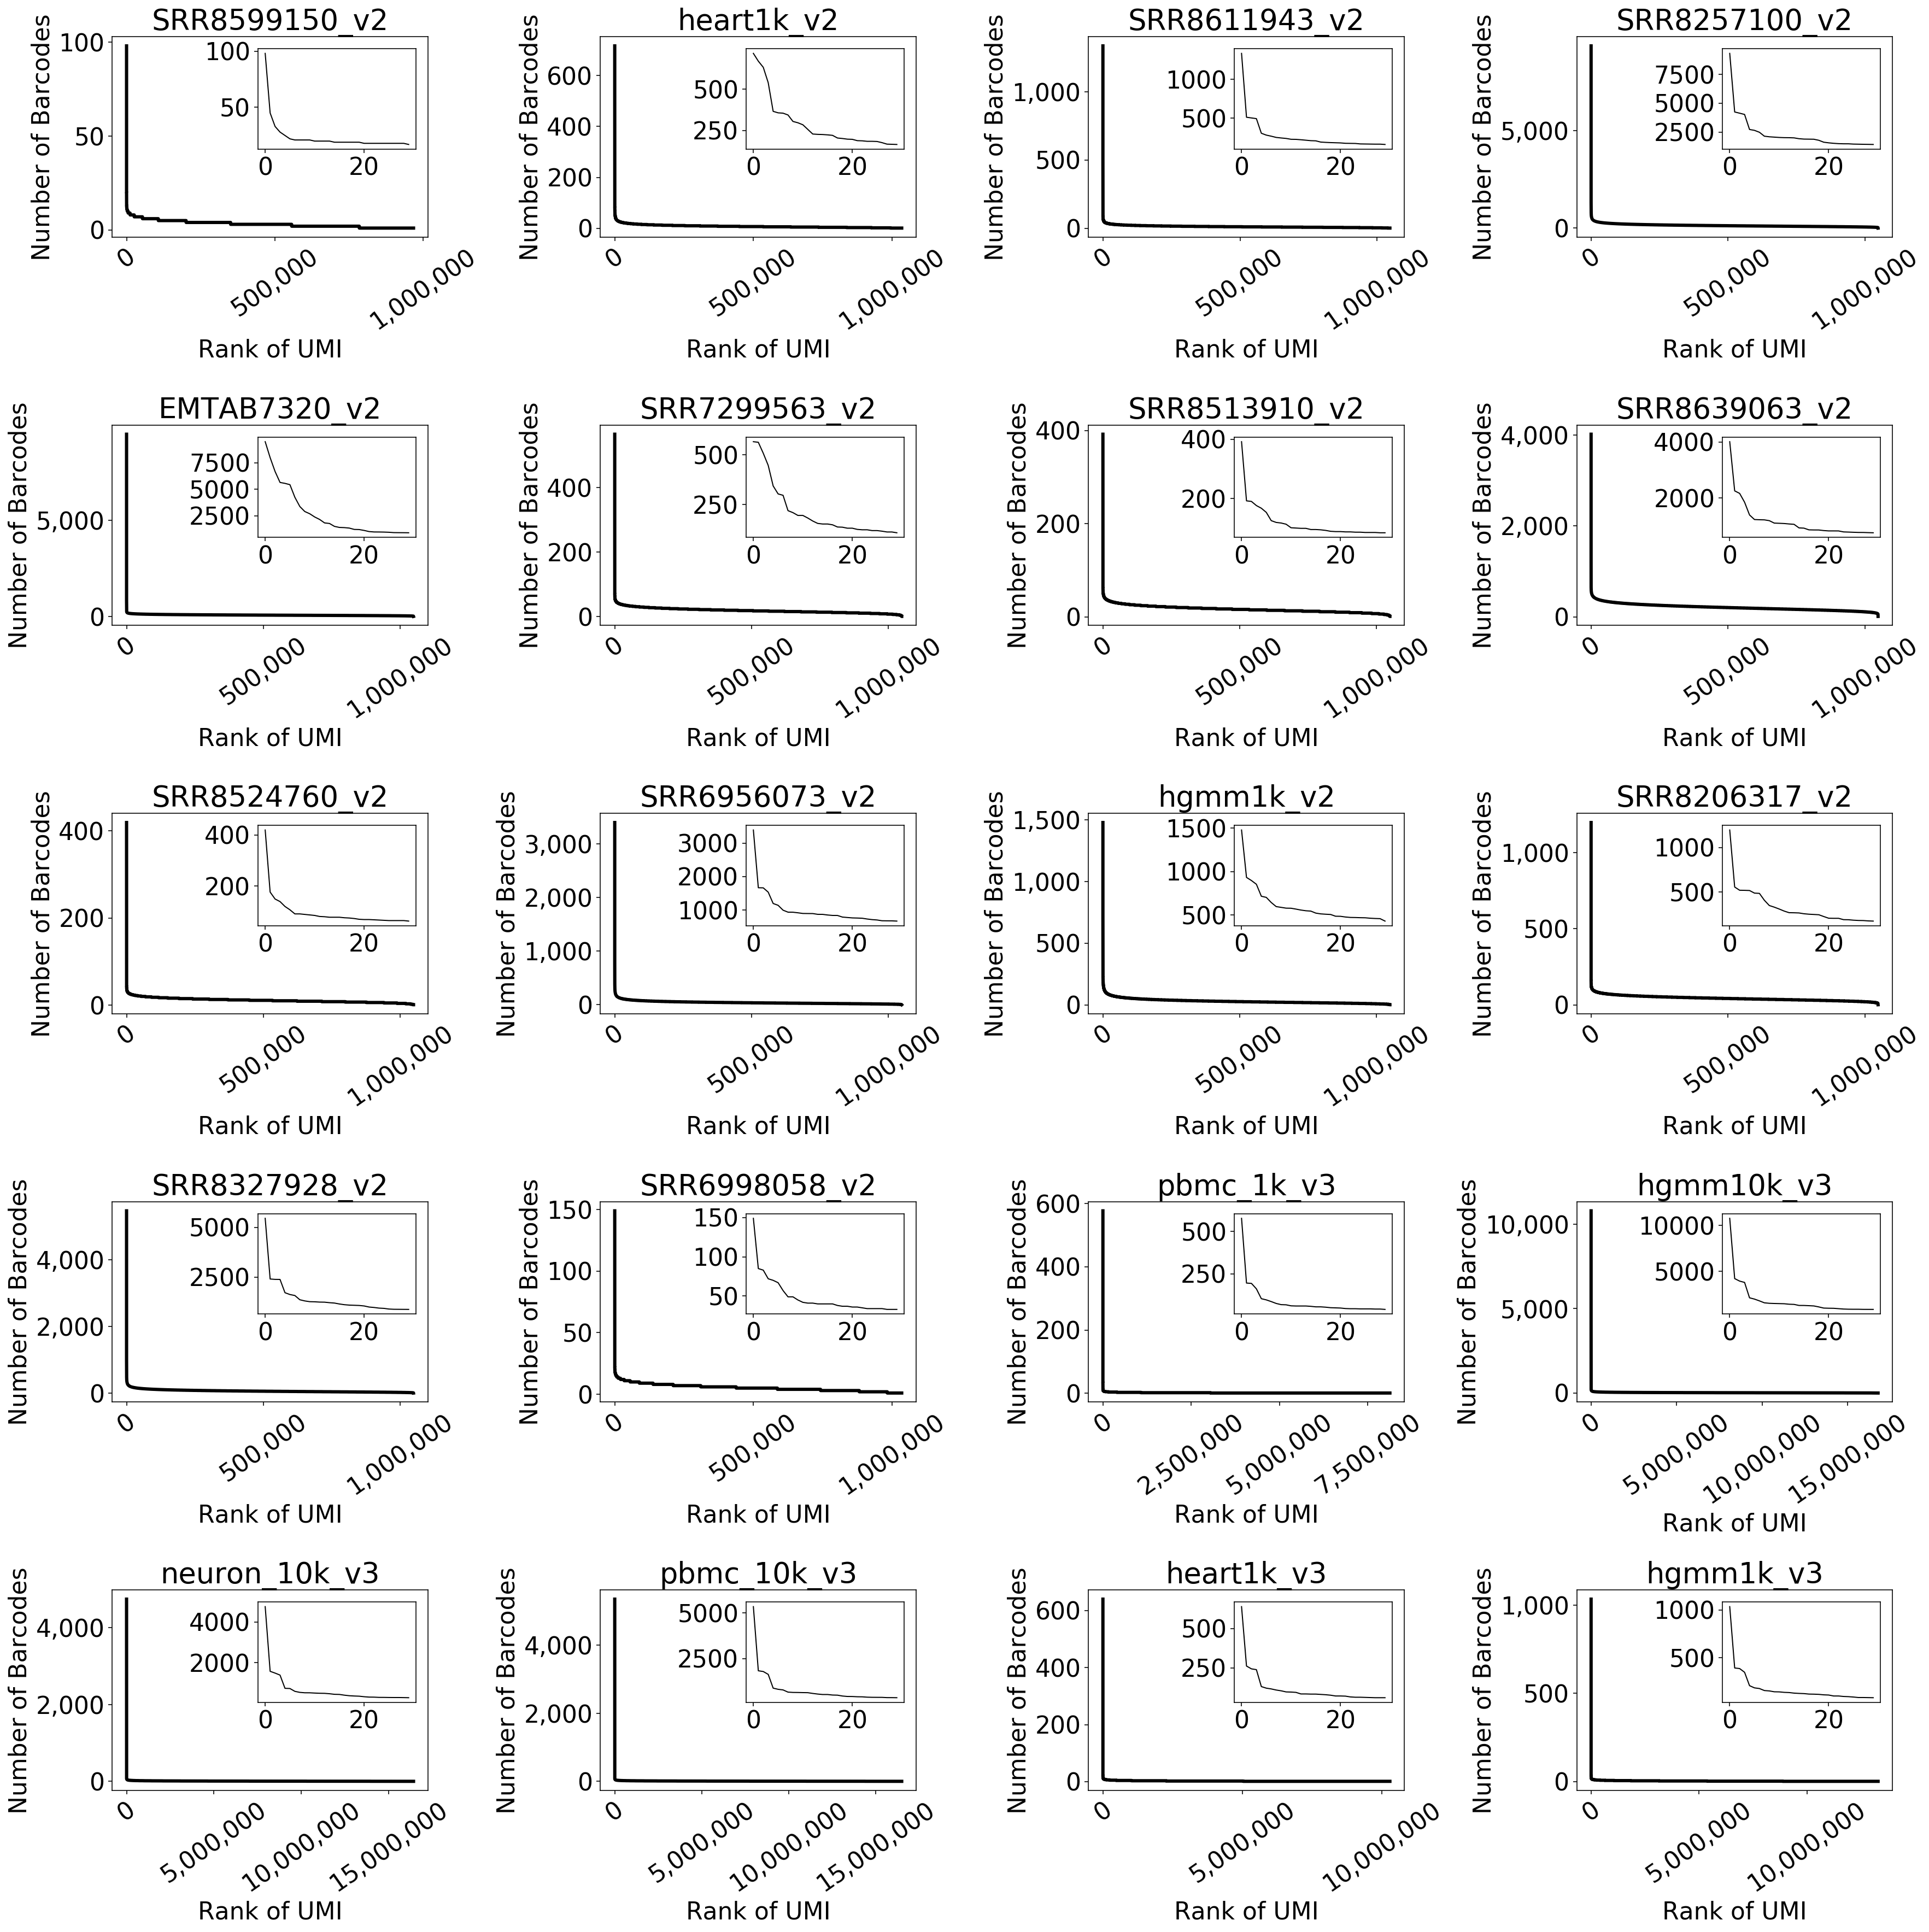

In [23]:
fig, axs = plt.subplots(5,4, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.75, wspace=0.5)
axs = axs.ravel()

for i in range(len(names)):
    top = 30
    thresh = 1
    
    counts = data[i]


    axs[i].plot(range(len(counts))[::-1], counts, color="k", linewidth=3)
    
    inset = inset_axes(axs[i], width="50%", height="50%", loc=1)
    parts = inset.plot(range(len(counts[-top::]))[::-1], counts[-top::], color="k", linewidth=1)

    axs[i].set_title(names[i])
    
    axs[i].set_xlabel("Rank of UMI")
    axs[i].set_ylabel("Number of Barcodes")
    
    axs[i].get_xaxis().set_visible(True)
    axs[i].get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axs[i].get_xaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))



    for tick in axs[i].get_xticklabels():
        tick.set_rotation(35)
plt.tight_layout()
plt.savefig("all_uniform.pdf")
plt.show()